## Analysis of USD/TRY Ratio btw 2005-2022 and Daily Future Ratio Forecasting

In [155]:
#Import required libraries

%matplotlib inline
import numpy as np
import warnings
import pandas as pd
from matplotlib import pyplot as plt

import datetime as dt
from datetime import date
from datetime import timedelta

import plotly.offline as py
import plotly.graph_objects as go

import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error

from bs4 import BeautifulSoup,SoupStrainer
import requests
import time
import pickle
from scipy.signal import find_peaks, argrelextrema

from selenium import webdriver
from selenium.webdriver.common.by import By

warnings.filterwarnings("ignore")
py.init_notebook_mode(connected=True)

## Download the history of USD/TRY ratio from yahoo finance through selenium webdriver

In [156]:
def download_historical_data(url):
    driver = webdriver.Firefox()
    driver.get(url)
    driver.implicitly_wait(5)
    download_button = "/html/body/div[1]/div/div/div[1]/div/div[3]/div[1]/div/div[2]/div/div/section/div[1]/div[1]/div[1]/div/div"
    xpath_to_download = driver.find_element(By.XPATH, download_button)
    xpath_to_download.click()
    max_button = "/html/body/div[1]/div/div/div[1]/div/div[3]/div[1]/div/div[2]/div/div/section/div[1]/div[1]/div[1]/div/div/div[2]/div/ul[2]/li[4]/button"
    xpath_to_max_button = driver.find_element(By.XPATH, max_button)
    xpath_to_max_button.click()
    apply_button = "/html/body/div[1]/div/div/div[1]/div/div[3]/div[1]/div/div[2]/div/div/section/div[1]/div[1]/button"
    xpath_to_apply_button = driver.find_element(By.XPATH, apply_button)
    xpath_to_apply_button.click()
    apply_button = "/html/body/div[1]/div/div/div[1]/div/div[3]/div[1]/div/div[2]/div/div/section/div[1]/div[1]/button"
    xpath_to_apply_button = driver.find_element(By.XPATH, apply_button)
    xpath_to_apply_button.click()
    download_button = "/html/body/div[1]/div/div/div[1]/div/div[3]/div[1]/div/div[2]/div/div/section/div[1]/div[2]/span[2]/a"
    xpath_to_download_button = driver.find_element(By.XPATH, download_button)
    xpath_to_download_button.click()
    
# download_historical_data(url="https://finance.yahoo.com/quote/TRY%3DX/history?p=TRY%3DX")

## Update the latest price data with already created historical data

In [157]:
def update_historical_data(df1, url):
    headers = {"User-Agent": "Mozilla/5.0"}
    source = requests.get(url, headers=headers).text
    soup = BeautifulSoup(source)

    table = soup.table
    table_rows = table.find_all('tr')
    table_ls = []

    for tr in table_rows:
        td = tr.find_all('td')
        row = [i.text for i in td]
        table_ls.append(row)

    df = pd.DataFrame(table_ls)

    new_cols = ['Date', 'Open', 'High', 'Low', 'Close', "Adj.Close", "Volume"]

    new_names_map = {df.columns[i]: new_cols[i] for i in range(len(new_cols))}
    df.rename(new_names_map, axis=1, inplace=True)


    df2 = df.dropna(axis=0)

    df2['Date'] = df2['Date'].str.strip()
    df2['Date'] = pd.to_datetime(df2['Date'], format='%b %d, %Y') # format=YYYY-MM-DD


    df2 = df2.set_index(df2["Date"].values)
    df2 = df2.replace(",", "", regex=True)

    df2[['Open', 'High', 'Low', 'Close', "Adj.Close"]] = df2[['Open', 'High', 'Low', 'Close', "Adj.Close"]].apply(
        pd.to_numeric)

    df2['Date'] = pd.to_datetime(df2['Date'], format='%Y-%m-%d')  # format=YYYY-MM-DD
    df2.set_index("Date",inplace=True,drop=True)
    frames = [df1, df2]
    
    result = pd.concat(frames).drop_duplicates().drop(["Adj.Close","Adj Close","Volume"],axis=1).sort_index()
    result = result.groupby(result.index).first()
    result["Day_Name"]=result.index.day_name()
    result = result.asfreq("B",method="ffill")
    return result

In [158]:
df = pd.read_csv("TRY=X.csv",parse_dates=True, index_col=0) #read historical data
url="https://finance.yahoo.com/quote/TRY%3DX/history?p=TRY%3DX" #url to fetch data of recent ratio

In [159]:
result = update_historical_data(df, url)

## Most recent data

In [160]:
result

,Open,High,Low,Close,Day_Name
Date,,,,,
2005-01-03,1.3455,1.3455,1.3368,1.3440,Monday
2005-01-04,1.3368,1.3510,1.3368,1.3510,Tuesday
2005-01-05,1.3545,1.3865,1.3545,1.3740,Wednesday
2005-01-06,1.3780,1.4058,1.3780,1.3925,Thursday
2005-01-07,1.3870,1.3940,1.3615,1.3940,Friday
...,...,...,...,...,...
2022-01-13,13.2397,13.6577,13.1492,13.2434,Thursday
2022-01-14,13.4994,13.6270,13.4438,13.5827,Friday
2022-01-17,13.4332,13.6191,13.3527,13.4332,Monday


## Take data between 2005-2021 and modify it with frequency of business days

In [161]:
start = pd.to_datetime("2005-01-01", format='%Y-%m-%d')
end = pd.to_datetime("2021-12-31", format='%Y-%m-%d')
    
def format_timeseries(df, start, end):

    df = df.loc[((df.index>start) & (df.index<=end))]
    # df = df.loc[(df.index>start)]
    
    df = df.resample("B").mean()
    df = df.asfreq("B",method="ffill")
    df["Week"]=df.index.isocalendar().week
    df["Day_Name"]=df.index.day_name()
    df = df.drop_duplicates().sort_index()
    return df

## Modified daily timeseries data

In [162]:
ts_df = format_timeseries(result, start=start, end=end)
ts_df

,Open,High,Low,Close,Week,Day_Name
Date,,,,,,
2005-01-03,1.34550,1.34550,1.33680,1.34400,1,Monday
2005-01-04,1.33680,1.35100,1.33680,1.35100,1,Tuesday
2005-01-05,1.35450,1.38650,1.35450,1.37400,1,Wednesday
2005-01-06,1.37800,1.40580,1.37800,1.39250,1,Thursday
2005-01-07,1.38700,1.39400,1.36150,1.39400,1,Friday
...,...,...,...,...,...,...
2021-12-27,10.72490,11.57180,10.72490,10.80710,52,Monday
2021-12-28,11.42289,11.90138,11.40058,11.52105,52,Tuesday
2021-12-29,11.80295,12.67110,11.78757,11.80312,52,Wednesday


## Take the "close" price data to analyze the trend and seasonality of timeseries 

In [163]:
y = ts_df["Close"].ffill().sort_index()

# Create figure
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=y.index, y=y.values))

fig.update_layout(
    paper_bgcolor='silver',
    plot_bgcolor='rgba(0,0,0,0)',
    legend_bordercolor="white",
    title={
        'text': "Daily Timeseries of USD/TRY Close Price Ratio (2005-2022)","x":0.5},
    title_font_color="black",
    xaxis_title="Date",
    yaxis_title="Close Price Ratio",
    legend_title="",
    font=dict(
        size=12,
        color="black"
    )
)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

py.iplot(fig)

## Graph function to show seasonal decompose of timeseries

In [164]:
def seasonal_decompose(y,n):
    decomposition = sm.tsa.seasonal_decompose(x=y, model='additive',extrapolate_trend='freq', period=n)
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()
    return decomposition

### Seasonal decompose of timeseries by period of 256 days

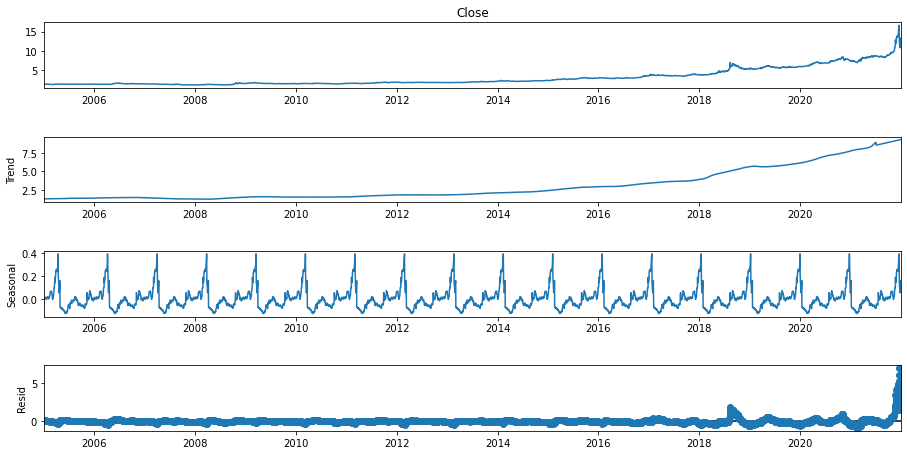

In [165]:
decomposed = seasonal_decompose(y, 256)

## Function for Testing Stationarity

#### Augmented Dickey-Fuller Test

In [166]:
def ADF_test(timeseries, dataDesc): 
    print("Null ADF Test Hypothesis: The process has a unit root, it is not trend stationary.")
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print(f'Result: The hypothesis is {"not " if dftest[1] > 0.05 else ""}rejected')
    print(f'Result: The series is {"not " if dftest[1] > 0.05 else ""}stationary')
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {}stationary with {}% confidence'.format(k, v, 'not ' if v < dftest[0] else '',
                                                                                100 - int(k[:-1])))

#### KPSS Test

In [167]:
def kpss_test(timeseries):
    print('Results of KPSS Test:')
    kpsstest = kpss(timeseries, nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic', 'p-value', 'Lags Used'])
    for key, value in kpsstest[3].items():
        kpss_output['Critical Value (%s)' % key] = value
    print("Null KPSS Test Hypothesis: The process is trend stationary.")
    print("Alternate Hypothesis: The series has a unit root (series is not stationary).")
    print(f'Result: The hypothesis is {"not " if kpss_output[1] > 0.05 else ""}rejected')
    print(f'Result: The series is {"not " if kpss_output[1] < 0.05 else ""}stationary')
    print(kpss_output)


In [168]:
kpss_test(y)
print("\n\n")
ADF_test(y, 'raw data')

Results of KPSS Test:
Null KPSS Test Hypothesis: The process is trend stationary.
Alternate Hypothesis: The series has a unit root (series is not stationary).
Result: The hypothesis is rejected
Result: The series is not stationary
Test Statistic            8.166858
p-value                   0.010000
Lags Used                41.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64



Null ADF Test Hypothesis: The process has a unit root, it is not trend stationary.
 > Is the raw data stationary ?
Test statistic = 3.608
P-value = 1.000
Result: The hypothesis is not rejected
Result: The series is not stationary
Critical values :
	1%: -3.4318340352231185 - The data is not stationary with 99% confidence
	5%: -2.862195763748743 - The data is not stationary with 95% confidence
	10%: -2.567119067159428 - The data is not stationary with 90% confidence


### Plot function for Rolling Statistic (Z-Score) for Testing Stationarity

In [169]:
def test_stationarity(timeseries, n, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=n).mean() 
    rolstd = pd.Series(timeseries).rolling(window=n).std()
    timeseries2 =  (timeseries - rolmean)/rolstd

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=timeseries.index, y=timeseries, name="Raw Data"))
    fig.add_trace(go.Scatter(x=timeseries2.index, y=timeseries2, name="Detrended (Window={}) (Z-Score)".format(n)))
    fig.add_trace(go.Scatter(x=rolmean.index, y=rolmean, name="Rolling Mean"))
    fig.add_trace(go.Scatter(x=rolstd.index, y=rolstd, name="Rolling Std (x10)"))
    return py.iplot(fig)

test_stationarity(y, 256, 'raw data')

## Train/Test Split

In [170]:
train = y.to_frame() # dataset to train
test = result["Close"].loc[(result.index>end)].drop_duplicates() # last X days for test  
predict_date = len(test) # the number of data points for the test set
train = train.asfreq(freq="B",method="ffill").dropna()
test = test.asfreq(freq="B",method="ffill").dropna()

## 2 Holt-Winter models to make predictions

In [171]:
def HoltsWinter(train, seasonal_periods, trend, seasonal, predict_date):
    model = HWES(train, seasonal_periods=seasonal_periods, trend=trend, seasonal=seasonal)
    fitted = model.fit()

    # Print out the training summary.

    # print(fitted.summary())

    sales_forecast = fitted.forecast(steps=predict_date)
    mse = ((sales_forecast - test) ** 2).mean()
    print("The Root Mean Squared Error = {}".format(mse))
    return sales_forecast

In [172]:
def holt_win_sea(y,train,test,seasonal_type,seasonal_period,predict_date):
 
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive damped trend + multiplicative seasonal')
        mse2 = ((fcast2 - test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x=test.index,
            y=test,
            name="test"       # this sets its legend entry
        ))

        fig.add_trace(go.Scatter(
            x=fcast1.index,
            y=fcast1,
            name="additive trend, additive seasonal"       # this sets its legend entry
        ))

        fig.add_trace(go.Scatter(
            x=fcast2.index,
            y=fcast2,
            name="additive damped trend, additive seasonal"       # this sets its legend entry
        ))
        return fit1, fit2, py.iplot(fig)
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped_trend')
        mse4 = ((fcast3 - test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fig = go.Figure()
              
        fig.add_trace(go.Scatter(
            x=test.index,
            y=test,
            name="test"       # this sets its legend entry
        ))

        fig.add_trace(go.Scatter(
            x=fcast3.index,
            y=fcast3,
            name="additive trend, multiplicative seasonal"       # this sets its legend entry
        ))
        
        fig.add_trace(go.Scatter(
            x=fcast4.index,
            y=fcast4,
            name="additive damped trend, multiplicative seasonal"       # this sets its legend entry
        ))
        return fit3, fit4, py.iplot(fig)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')
    

In [173]:
sales_forecast = HoltsWinter(train=train, seasonal_periods=256, trend="add", seasonal="mul", predict_date=predict_date+16)

The Root Mean Squared Error = 0.05901599367083124


In [174]:
# some time later...
filename = 'finalized_model.sav'
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
fitted_val = loaded_model.fit()

In [175]:
result = fitted_val.forecast(predict_date+15)

In [176]:

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=test.index,
    y=test,
    name="Test"       # this sets its legend entry
))

fig.add_trace(go.Scatter(
    x=result.index,
    y=result,
    name="Holt Winter Model Forecast"       # this sets its legend entry
))
py.iplot(fig)